<a href="https://colab.research.google.com/github/YE-Hordijk/DeepLearning2/blob/main/Copy_of_Task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

In [2]:
!wget https://surfdrive.surf.nl/files/index.php/s/B8emtQRGUeAaqmz/download
!unzip download -d ./

--2022-11-12 14:13:14--  https://surfdrive.surf.nl/files/index.php/s/B8emtQRGUeAaqmz/download
Resolving surfdrive.surf.nl (surfdrive.surf.nl)... 145.100.27.67, 2001:610:108:203b:0:a11:da7a:5afe
Connecting to surfdrive.surf.nl (surfdrive.surf.nl)|145.100.27.67|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 319538742 (305M) [application/zip]
Saving to: ‘download’

download            100%[===================>] 304.74M  5.36MB/s    in 45s     

2022-11-12 14:14:00 (6.79 MB/s) - ‘download’ saved [319538742/319538742]

Archive:  download
  inflating: ./images.npy            
  inflating: ./labels.npy            


In [39]:
images = np.load("images.npy").reshape(18000, 150*150)
labels = np.load("labels.npy")
tot = np.append(images, labels, axis=1)
tot = tot.astype("float32")
np.random.shuffle(tot)
images, labels = tot[:,:22500].reshape(18000, 150, 150), tot[:,22500:]
images = images/255

#use the first line for regression, the second for classification and neither for multi-head
# labels = labels[:,0] + labels[:,1]/60
# labels = (labels[:,0]*2 +labels[:,1]/30).astype("int32")

trainx, trainy = images[:int(18000*0.2)], labels[:int(18000*0.2)]
testx, testy = images[int(18000*0.8):], labels[int(18000*0.8):]

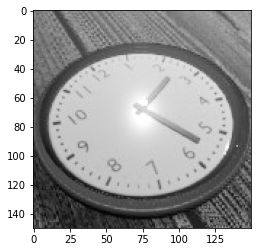

In [4]:
plt.imshow(images[0], cmap="gray")
plt.show()

In [53]:
def lossfuncreg(ytrue, ypred):
  return tf.math.minimum(tf.sqrt(((ytrue+12 - ypred)%12)**2), tf.sqrt(((ypred+12 - ytrue)%12)**2))

def lossfuncmulti(ytrue, ypred):
  return tf.math.minimum(tf.sqrt(((ytrue+60 - ypred)%60)**2), tf.sqrt(((ypred+60 - ytrue)%60)**2))

In [51]:
#regression model
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, (10, 10), strides=(3, 3), activation="relu", input_shape=(150, 150, 1)))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Conv2D(64, (3, 3), activation="relu"))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Conv2D(128, (3, 3), activation="relu"))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Dropout(.4))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256, activation="relu"))
model.add(keras.layers.Dense(64, activation="relu"))
model.add(keras.layers.Dense(1, activation="linear"))
model.summary()

model.compile(
    loss=lossfuncreg,
    optimizer=keras.optimizers.Adam(learning_rate=0.0002,beta_1=0.9,beta_2=0.999, epsilon=1e-07),
    metrics=[keras.metrics.MeanSquaredError()]
)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_43 (Conv2D)          (None, 47, 47, 32)        3232      
                                                                 
 max_pooling2d_41 (MaxPoolin  (None, 23, 23, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_44 (Conv2D)          (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 10, 10, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_45 (Conv2D)          (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_43 (MaxPoolin  (None, 4, 4, 128)       

In [33]:
#classification model
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, (10, 10), strides=(3, 3), activation="relu", input_shape=(150, 150, 1)))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Conv2D(64, (3, 3), activation="relu"))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Conv2D(128, (3, 3), activation="relu"))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Dropout(.4))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256, activation="relu"))
model.add(keras.layers.Dense(24, activation="softmax"))
model.summary()

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.0002,beta_1=0.9,beta_2=0.999, epsilon=1e-07),
    metrics=["accuracy"]
)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 47, 47, 32)        3232      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 23, 23, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 10, 10, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 4, 4, 128)       

In [54]:
#multi head model
inp = keras.Input(shape=(150, 150, 1))

x = keras.layers.Conv2D(32, (10, 10), strides=(3, 3), activation='relu')(inp)
x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = keras.layers.Dropout(.4)(x)
x = keras.layers.Flatten()(x)

hour = keras.layers.Dense(256, activation='relu')(x)
hour = keras.layers.Dense(12, activation='softmax', name='hour')(hour)

minute = keras.layers.Dense(256, activation='relu')(x)
minute = keras.layers.Dense(64, activation='relu')(minute)
minute = keras.layers.Dense(1, activation='linear', name='minute')(minute)

model = keras.Model(inputs=inp, outputs=[hour, minute])

model.compile(
    loss=["sparse_categorical_crossentropy", lossfuncmulti],
    optimizer=keras.optimizers.Adam(learning_rate=0.0002,beta_1=0.9,beta_2=0.999, epsilon=1e-07),
    metrics=["accuracy", "mse"]
)

In [58]:
# history = model.fit(trainx, trainy, epochs=10)                      #use this for regression and classification
history = model.fit(trainx, [trainy[:,0], trainy[:,1]], epochs=100)    #use this for multi-head
model.save("task2model")

Epoch 1/100
113/113 [==============================] - 24s 214ms/step - loss: 14.1460 - hour_loss: 2.3046 - minute_loss: 11.8414 - hour_accuracy: 0.1772 - hour_mse: 41.4425 - minute_accuracy: 0.0189 - minute_mse: 1297.4720
Epoch 2/100
113/113 [==============================] - 23s 203ms/step - loss: 13.7749 - hour_loss: 2.2723 - minute_loss: 11.5026 - hour_accuracy: 0.1972 - hour_mse: 41.4428 - minute_accuracy: 0.0175 - minute_mse: 1345.0913
Epoch 3/100
113/113 [==============================] - 25s 222ms/step - loss: 13.4964 - hour_loss: 2.2328 - minute_loss: 11.2635 - hour_accuracy: 0.2106 - hour_mse: 41.4432 - minute_accuracy: 0.0183 - minute_mse: 1381.5687
Epoch 4/100
113/113 [==============================] - 23s 203ms/step - loss: 13.1354 - hour_loss: 2.1939 - minute_loss: 10.9416 - hour_accuracy: 0.2164 - hour_mse: 41.4436 - minute_accuracy: 0.0197 - minute_mse: 1412.6241
Epoch 5/100
113/113 [==============================] - 24s 212ms/step - loss: 12.9471 - hour_loss: 2.1732 - 

In [69]:
predmodel = keras.models.load_model("./task2model", custom_objects={"lossfuncmulti":lossfuncmulti})
predictions = predmodel.predict(testx[:100])
# print(predictions[0])
# print("joe")
# print(predictions[1])
for i in range(100):
    print(np.argmax(predictions[0][i]), predictions[1][i][0]%60)
    print(testy[i])

4/4 [==============================] - 0s 69ms/step
7 6.804859638214111
[7. 6.]
8 41.006126403808594
[ 7. 46.]
11 51.710371017456055
[ 0. 51.]
4 19.385009765625
[ 5. 19.]
0 1.8755120038986206
[1. 0.]
8 42.47368621826172
[ 7. 45.]
2 56.29664325714111
[ 2. 58.]
11 54.3810338973999
[11. 54.]
3 52.571807861328125
[ 4. 55.]
2 50.87310791015625
[ 3. 50.]
9 38.67195701599121
[ 9. 32.]
7 52.99835777282715
[9. 0.]
11 29.50044822692871
[10. 29.]
10 33.32296562194824
[11. 19.]
2 45.888832092285156
[ 2. 50.]
8 39.32354164123535
[ 9. 11.]
2 59.822284549474716
[ 2. 58.]
9 37.77297401428223
[10. 38.]
6 6.671698570251465
[6. 4.]
4 23.88148307800293
[ 4. 23.]
8 27.936086654663086
[ 8. 25.]
10 18.348363876342773
[10. 18.]
1 0.4949675500392914
[0. 0.]
4 20.62916374206543
[ 4. 35.]
8 49.584898948669434
[ 8. 53.]
9 9.840912818908691
[ 9. 11.]
2 37.86299133300781
[ 2. 42.]
6 43.15958595275879
[ 6. 46.]
1 26.048686981201172
[ 0. 18.]
11 26.584747314453125
[ 8. 59.]
2 45.03986644744873
[ 2. 46.]
2 13.11323738